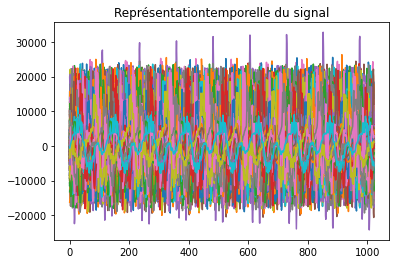

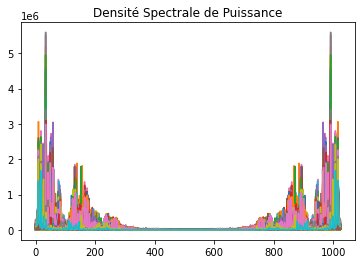

[[ 1.90169288 -0.80393567 -1.22380629 ... -0.23203427 -1.47307661
   0.73980062]
 [ 1.47640859 -0.68015694 -1.4949173  ... -0.30913929 -2.061416
  -1.27912833]
 [ 1.3000153  -0.96935618 -0.81895323 ...  0.12046424 -1.73790997
  -0.83748049]
 ...
 [-2.02418407  0.02732601  0.80256678 ... -1.38809548  1.59390509
   1.34731279]
 [-1.05944153 -0.6339699   0.79232411 ... -1.59292189  0.59107017
   0.24832859]
 [-1.48708914 -0.01592402  0.60998485 ... -1.40270613  0.70031748
   0.5051313 ]]
[20.73962645 16.12085946 12.96282707 11.12370241 10.79471226  2.72849012
  3.18386559  4.459491    4.93707372  6.00154133  6.25459112  8.04288822
  7.63262   ] [[ 4.05357087e-01 -2.09296558e-01 -2.16499114e-02 -2.80635276e-01
   3.57944063e-01  3.94176718e-03 -1.64581770e-02  2.89431742e-01
   6.69685593e-01 -1.59006720e-01 -1.32282233e-01 -9.27396990e-02
  -2.47677249e-02]
 [-4.28488015e-01 -7.71746939e-02  3.63733311e-01  4.36040845e-01
  -2.97034266e-01  1.06952800e-01 -1.54687739e-02  2.97972146e-01
 

ValueError: operands could not be broadcast together with shapes (13,13) (900,13) 

In [96]:
import os
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy
import base
import TPClassif 

prefixe=['aa','ee','eh','eu','ii','oe','oh','oo','uu','yy']

baseApprentissage=[]
baseTest=[]
baseEntiere=[]

listVecteurCoefficients=[]
listVecteurCoefficientsApprentissage=[]

vecteurClasseApprentissage=[]

#recuperation des noms des fichiers
for nomFichier in os.listdir('Signaux'):
    #, leur fe et les echantillons dans le .wav
    (fe,echantillons)=scipy.io.wavfile.read('Signaux/'+nomFichier)
    baseEntiere.append(nomFichier)
    
    #affecte un numero de classe a chaque fichier
    numeroClasse=prefixe.index(nomFichier[0:2])
    
    #affichage
    plt.figure(1) 
    plt.plot(echantillons) 
    plt.title('Représentationtemporelle du signal')
    #transformee de Fourier rapide
    dsp=numpy.abs(numpy.fft.fft(echantillons)) 
    plt.figure(2) 
    plt.plot(dsp)
    plt.title('Densité Spectrale de Puissance') 
    
    #calcul des coefficients mfcc
    vecteurCoefficients=base.mfcc(echantillons, fe, len(echantillons)/fe,len(echantillons)/fe)    
    listVecteurCoefficients.append(vecteurCoefficients[0])
    
plt.show()

#on retire 10 fichiers par type de son de la base pour que la base d'apprentissage
#comprennent 90% des individus (les 10 derniers)
baseEntiere.sort()
for i in baseEntiere:
    if('90'in i or '91'in i or '92'in i or '93'in i or '94'in i or '95'in i or '96'in i or '97'in i or '98'in i or '99'in i):
        baseTest.append(i)
    else:
        baseApprentissage.append(i) 
        
#on itere sur la baseApprentissage pour en déduire la matrice
#des mfcc
for i in baseApprentissage:
    #, leur fe et les echantillons dans le .wav
    (fe,echantillons)=scipy.io.wavfile.read('Signaux/'+i)
    
    #affecte un numero de classe a chaque fichier
    #pour aller de 1 à 10, +1
    numeroClasse=prefixe.index(i[0:2])+1
    vecteurClasseApprentissage.append(numeroClasse)
    
    #calcul des coefficients mfcc
    vecteurCoefficients=base.mfcc(echantillons, fe, len(echantillons)/fe,len(echantillons)/fe)    
    listVecteurCoefficientsApprentissage.append(vecteurCoefficients[0])

#on convertit la liste en array car TPClassif utilise des array
arrayVecteurClasseApprentissage=numpy.array(vecteurClasseApprentissage)
#print(listVecteurCoefficientsApprentissage)
#print(type(arrayVecteurClasseApprentissage))
#print(len(baseApprentissage))
#print(len(baseTest))
#print(listVecteurCoefficients)
matrixVecteursCoeffApprentissage = numpy.array(listVecteurCoefficientsApprentissage)
#print("verification de la forme de la matrice N*P :")
#print(numpy.shape(matrixVecteursCoeffApprentissage))
#print(baseTest)

#on assimile la generation d'un son a une operation de filtrage

#implementation de l'AFD
#calcul centres des gravite
centreGravites=TPClassif.CalculerCentresGravite(matrixVecteursCoeffApprentissage,arrayVecteurClasseApprentissage)
#print(centreGravites)

#centre et reduit les individus
individusCentresReduits=TPClassif.CalculerIndividusCentresReduits(matrixVecteursCoeffApprentissage,centreGravites)
print(individusCentresReduits)

centreGravites=TPClassif.CalculerCentresGravite(individusCentresReduits,arrayVecteurClasseApprentissage)
#print(centreGravites)

#calcul des variances, totale, intra et interclasse
[vt,va,ve]=TPClassif.CalculerVariances(individusCentresReduits,arrayVecteurClasseApprentissage,centreGravites)
#print(variances)

#calcul matrices de covariance totale, intra et interclasse
[ct,ca,ce]=TPClassif.CalculerMatricesCovariance(individusCentresReduits,arrayVecteurClasseApprentissage,centreGravites)
#print(matricesDeCovariance)

#maximisation du nouveau critere
CAinv=numpy.linalg.inv(ca)
CAinvCE=CAinv*ce
valp, vecp = numpy.linalg.eig(CAinvCE)
print(valp,vecp)

#projection sur les nvx axes
#trouver le bon ordre et la bonne transposee